# Multi-Layer Perceptron from the scratch

Nowadays, multi-Layer neural network has been proved to be a powerful tool in many data science problems. Though many existing packages have provided the interfaces to call this function (e.g. scikit-learn), it would be good to write some toy model by your own. Through this practice, you will gain some experience in software engineering. More importantly, you will understand the underlying mathmatics better and know how to fix the troubles when you run the code from the existing softwares. In the tutorial, we will continue to use the wine data and figure out how to write our own MLP classfier.

Let us start with the example in the previous lecture
```
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
```
<img src="img/MLP.jpeg" style="width: 800px;"/>
<center> Figure 1, the MLP model used in this lecture</center>

You should be able to understand most of the parameters at the moment. To realize a minimum version of MLP, we can try to implement the following parameters into our model:
- hidden_layer_sizes: to make life easier, let us just consider 2 hidden layer models
- max_iter: maximum number of iteractions
- learning_rate_init: 

Note that we will completely ignore the terms related to regularization. 
We also need to choose the proper loss and activation functions. For simplicity, let's choose the followings,
- Activation: Sigmoid
- Loss: logloss

## Forward propagation
$
\begin{align}
h_1 &= w_1\cdot x + b_1\\
z_1 & = f(h_1)\\
h_2 &= w_2\cdot f_1(w_1\cdot x + b_1)) + b_2 = w_2\cdot z_1 + b_2\\
z_2 & = f(h_2)\\
h_3 &= w_3\cdot f_2((w_2\cdot f_1(w_1\cdot x + b_1)) + b_2)) + b_3 = w_3\cdot z_2 + b_3\\
y` &= f_3(h_3) \\
\end{align}
$

## Loss function (log loss): 

Logloss function is a popular choice for classification problem. In this scheme, the target values represented by an array of values betwen 0 and 1 (e.g., y=[0, 0, 1], y\`=[0.1, 0.1, 0.9]))
\begin{align}
L = \sum y\log y` 
\end{align}



## Back propagation

$
\begin{align}
%\frac{\partial L}{\partial y} & = y-Y \\
\Delta_3 & = \frac{\partial L}{\partial z3} = \frac{\partial L}{\partial y`} \frac{\partial y`}{\partial z_3} = y`-Y \\
\frac{\partial L}{\partial w_3}& = \Delta_3 \cdot h_2,~~~
\frac{\partial L}{\partial b_3} = \Delta_3, ~~~ 
\frac{\partial L}{\partial h_2} = \Delta_3 \cdot w_3 \\
\Delta_2 & = \frac{\partial L}{\partial h_2} \frac{\partial h_2}{\partial z_2} = \Delta_3 \cdot w_3 (1-h_2)h_2\\
\frac{\partial L}{\partial w_2} & = \Delta_2 h_1,~~~
\frac{\partial L}{\partial b_2} = \Delta_2 ~~~
\frac{\partial L}{\partial h_1} = \Delta_3 \cdot w_2\\
\Delta_1 & = \frac{\partial L}{\partial h_1} \frac{\partial h_1}{\partial z_1} = \Delta_2 \cdot w_2 (1-h_1)h_1\\
\frac{\partial L}{\partial w_2} & = \Delta_1 \cdot x,~~~
\frac{\partial L}{\partial b_2} = \Delta_1 \\
\end{align}
$



In [1]:
%matplotlib inline

import numpy as np
import sys
import matplotlib.pyplot as plt

class my_MLPClassifier(object):
    """
    Basic MultiLayer Perceptron (MLP) neural network.
    Args:
    hidden layer: []
    max_iterations: []
    """
    def __init__(self, hidden, max_iter, 
                 learning_rate=0.001, decay_rate=0.999, 
                 activation='sigmoid', loss='logloss'):
        """
        :param hidden: number of hidden neurons
        :param iterations: how many epochs
        :param learning_rate: initial learning rate
        """
        # initialize input parameters
        self.iterations = max_iter
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.n_hid1, self.n_hid2 = hidden[0], hidden[1]
        self.activation_method = activation
        self.loss_method = loss
        
    def fit(self, x, y):      
        """
        input: [178, 13] = [example, wine features]
        output: [178, 3] = [example, class probabilities] 
        """
        # Initialize the weights and bias according to the input/target data
        dim_in, dim_out = x.shape[1], 3
        self.w1 = np.random.randn(dim_in, self.n_hid1) # [13,4] -- 52 weights 
        self.w2 = np.random.randn(self.n_hid1, self.n_hid2) # [4,4] -- 16 weights
        self.w3 = np.random.randn(self.n_hid2, dim_out) # [4,3] -- 12 weights
        self.b1 = np.random.randn(1,self.n_hid1) # [1,4] -- 4 biases
        self.b2 = np.random.randn(1,self.n_hid2) # [1,4] -- 4 biases
        self.b3 = np.random.randn(1,dim_out)  # [1,3] -- 3 bias
        loss_hist = [] # track loss for printing
        
        for i in range(self.iterations):
            # forward
            (h1,h2,y_) = self.forward(x)
            cost = self.loss_function(y_,y) 
            loss_hist.append(cost)
            
            # backprop
            delta3 = (y_-y)
            gradw3 = np.dot(np.transpose(h2),delta3)
            gradb3 = np.sum(delta3, axis = 0)
            delta2 = np.dot(delta3, np.transpose(self.w3)) * self.grad_activation(h2)
            gradw2 = np.dot(np.transpose(h1),delta2)
            gradb2 = np.sum(delta2, axis=0)  
            delta1 = np.dot(delta2, np.transpose(self.w2)) * self.grad_activation(h1)
            gradw1 = np.dot(np.transpose(x),delta1)
            gradb1 = np.sum(delta1, axis=0)
            
            # update parameters
            learning_rate = self.learning_rate * (self.decay_rate**i)
            self.w3 -= learning_rate*gradw3
            self.b3 -= learning_rate*gradb3
            self.w2 -= learning_rate*gradw2
            self.b2 -= learning_rate*gradb2
            self.w1 -= learning_rate*gradw1
            self.b1 -= learning_rate*gradb1
            if i%100==0 or i+1==self.iterations:
                print('activation function: {:s}, loss function: {:s} = {:8.3f}, iterations: {:d}, learning rate: {:6.4f}'
                .format(self.activation_method, self.loss_method, round(cost,3), i, learning_rate))
        self.weights = (self.w3, self.w2, self.w1)
        self.bias = (self.b3, self.b2, self.b1)
        
        # plot the training curve
        plt.title('training curve')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(np.arange(0,self.iterations),loss_hist)
        plt.show()
  
    def loss_function(self,y_,y): 
        m = len(y)
        if self.loss_method == 'logloss':
            y_ /= y_.sum(axis=1)[:, np.newaxis]
            return -1 * np.sum(y * np.log(y_))/len(y)
        else:
            raise NotImplementedError
        
    def hid_activation(self,x): 
        if self.activation_method == 'sigmoid':
            return 1./(1+np.exp(-x))
        else:
            raise NotImplementedError

    def grad_activation(self,x):
        if self.activation_method == 'sigmoid': 
            return x * (1-x)
        else:
            raise NotImplementedError

    def out_activation(self, x): 
        if self.loss_method == 'logloss':
            return np.exp(x)/np.sum(np.exp(x),axis=1)[:, np.newaxis] 
        else:
            raise NotImplementedError
        
    def forward(self,x):
        z1 = np.dot(x,self.w1)+self.b1
        h1 = self.hid_activation(z1)
        z2 = np.dot(h1,self.w2)+self.b2
        h2 = self.hid_activation(z2)
        z3 = np.dot(h2,self.w3)+self.b3
        y_ = self.out_activation(z3) 
        return(h1,h2,y_)
    
    def predict(self, x):
        (h1, h2, y) = self.forward(x)
        y_ = np.zeros(y.shape[0],int) 
        # array to reshape predictions to (178,)
        for i in range(len(y)):
            for j in range(len(y[i])):
                y[i,j] = round(y[i,j],0)
            y_[i] = np.argmax(y[i])
        return y_



In [2]:
## Obtain the data
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, OneHotEncoder
data=load_wine()
x, Y = data.data, data.target

## preprocess the data

As usual, it is important to process the data as follows:
- x, it is recommended to normalize x for NN before the fitting through the `StandardScaler` in sklearn. 
- Y, if it is a classification problem, we need to transform Y to a set of arrays with 0 or 1. For instance, there exist four classes (1, 2, 3, 4), we need to transform them to [1,0,0,0], [0,1,0,0], [0,0,1,0] and [0,0,0,1]. Fortunately, this can be done via `OneHotEncoder` in sklearn as well.

In [3]:
scaler = StandardScaler()  
scaler.fit(x)  
x0 = scaler.transform(x)
Y0 = OneHotEncoder().fit_transform(np.expand_dims(Y, axis=1)).toarray()
print(x[0])
print(x0[0])
print(Y[0])
print(Y0[0])

[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
[ 1.51861254 -0.5622498   0.23205254 -1.16959318  1.91390522  0.80899739
  1.03481896 -0.65956311  1.22488398  0.25171685  0.36217728  1.84791957
  1.01300893]
0
[1. 0. 0.]


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


activation function: sigmoid, loss function: logloss =    1.447, iterations: 0, learning rate: 0.0100
activation function: sigmoid, loss function: logloss =    0.045, iterations: 100, learning rate: 0.0090
activation function: sigmoid, loss function: logloss =    0.019, iterations: 199, learning rate: 0.0082


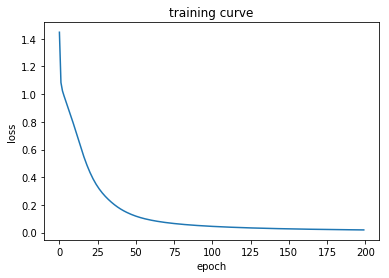

In [4]:
### mlp parameters
my_mlp = my_MLPClassifier(hidden=[4,2], max_iter=200, learning_rate=0.01)
my_mlp.fit(x0, Y0)

In [5]:
y_ = my_mlp.predict(x0)
count = len(y_[y_==Y])
print(count)

178


In [6]:
print('accuracy after {:4d} iterations is {:6.2f}%'.format(my_mlp.iterations, 100*count/len(y_)))

accuracy after  200 iterations is 100.00%
